<a href="https://colab.research.google.com/github/Arju-Jawla/Mean-Sea-Level-Anomalies/blob/main/MSLA_03_POLY_TREND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.6 MB/s eta 0:00:00


In [ ]:
!pip install ctime

In [ ]:
import numpy as np                           #numerical python library
import pandas as pd                          #data manipulation and analysis library

%matplotlib inline
import matplotlib.pyplot as plt              #plotting library

from netCDF4 import Dataset                  #reading netcdf files

import cftime                                #for time conversion
import datetime                              #for date manipulation
from datetime import datetime

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [ ]:
#load nc file from google drive
ncfile = '/content/drive/MyDrive/Project Learnings/Data/dt_global_satellite_sla_199302_202305.nc'

In [ ]:
# Open the netCDF file specified by 'ncfile' in read-only mode ('r')
# and assign it to the file handle 'fh'
fh = Dataset(ncfile, mode = 'r')

In [ ]:
#extracting the variable
sla = fh.variables['sla'][:]
lon  = fh.variables['longitude'][:]
lat  = fh.variables['latitude'][:]
time_var = fh.variables['time']

In [ ]:
dates = cftime.num2date(time_var[:], units=time_var.units)
dates_converted = [datetime(d.year, d.month, d.day) for d in dates]

In [ ]:
# Define coordinates for each port (approximate)
# Each subregion will cover 1x1 degree around the port
ports = {
    "Vishakhapatnam": {"lat": 17.7, "lon": 83.3},
    "Kandla": {"lat": 23.0, "lon": 70.2},
    "Mumbai": {"lat": 19.0, "lon": 72.8},
    "Paradip": {"lat": 20.3, "lon": 86.6},
    "Cochin": {"lat": 9.9, "lon": 76.3}
}

In [ ]:
# Function to get index range for a specified grid point with 1x1 degree tolerance
def get_grid_indices(lat, lon, lat_values, lon_values, tolerance=0.5):
    lat_indices = np.where((lat_values >= lat - tolerance) & (lat_values <= lat + tolerance))[0]
    lon_indices = np.where((lon_values >= lon - tolerance) & (lon_values <= lon + tolerance))[0]
    return lat_indices, lon_indices

In [ ]:
# Loop through each port and extract data
subregion_data = {}                                          #creates empty dict
for port, coords in ports.items():
    lat_idx, lon_idx = get_grid_indices(coords["lat"], coords["lon"], lat, lon)

    # Extract temperature data for the subregion
    subregion_sla = sla[:, lat_idx[0]:lat_idx[-1] + 1, lon_idx[0]:lon_idx[-1] + 1]
    subregion_sla_mean = np.mean(subregion_sla, axis=(1, 2))  # Mean over spatial dimensions (lat, lon)

    # Store in dictionary
    subregion_data[port] = subregion_sla_mean

In [ ]:
# Create a DataFrame from the subregion data
data = pd.DataFrame(subregion_data)
data['Date'] = dates_converted
data.set_index('Date', inplace=True)

In [ ]:
# Create a time variable (e.g., ordinal date)
data['time'] = np.arange(len(data))

In [ ]:
# Initialize dictionary to store results
poly_trend_results = {}

In [ ]:
# Fit a polynomial regression (degree 2) for each port
for port in ['Vishakhapatnam', 'Kandla', 'Mumbai', 'Paradip', 'Cochin']:
    # Set up polynomial features
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(data[['time']])  # Creates t and t^2 features

    # Define target variable
    y = data[port]

    # Fit polynomial regression model
    model = LinearRegression()
    model.fit(X_poly, y)

    # Save model parameters and score
    poly_trend_results[port] = {
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'r_squared': model.score(X_poly, y)
    }

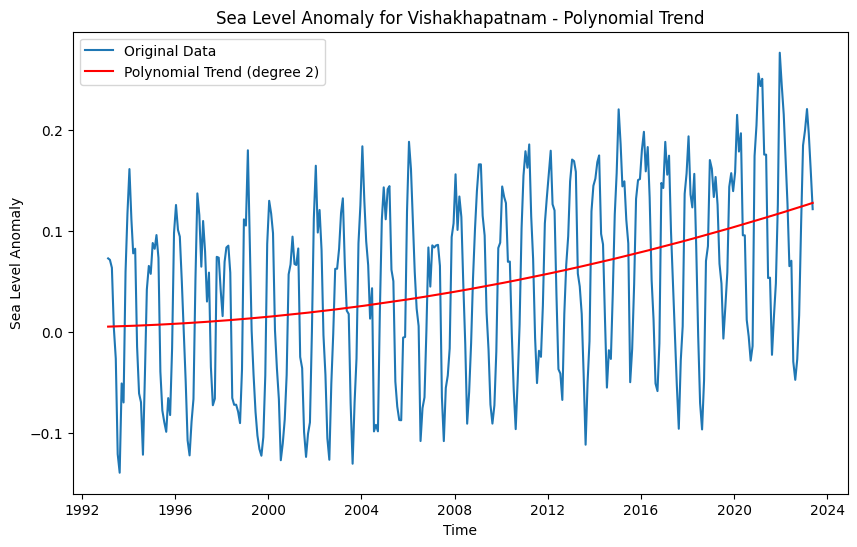

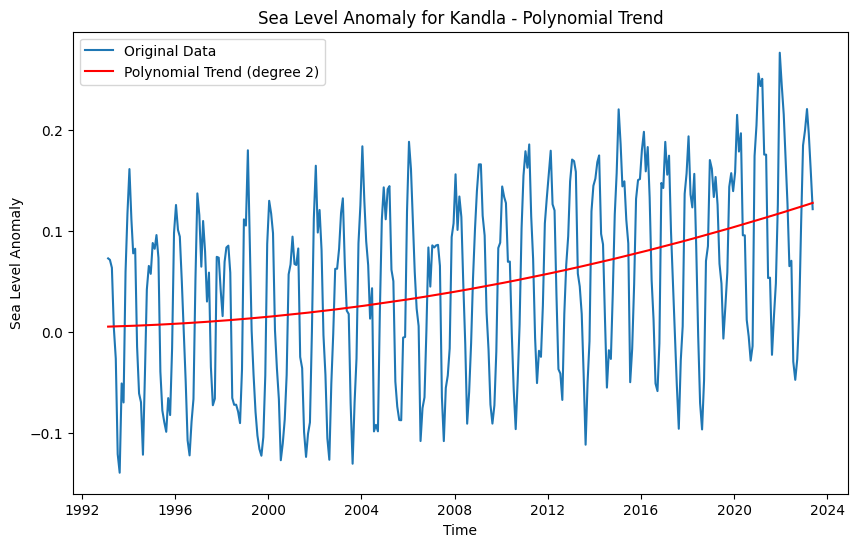

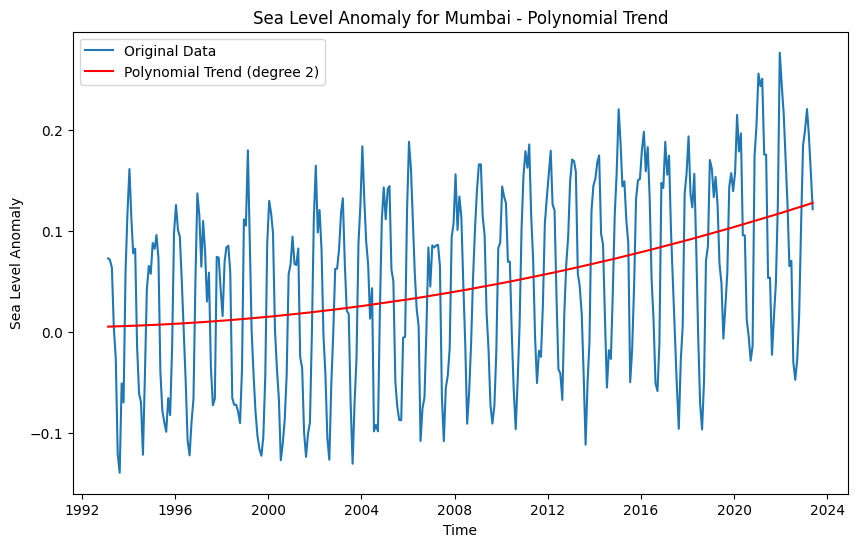

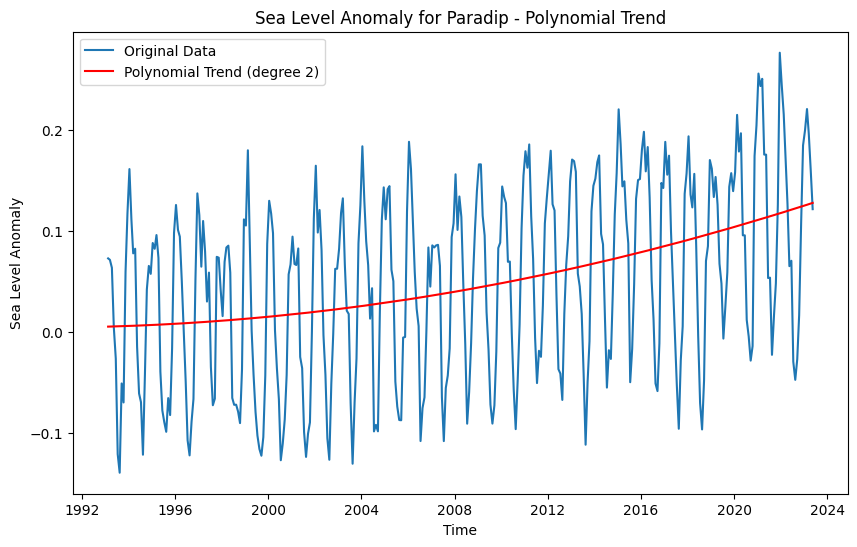

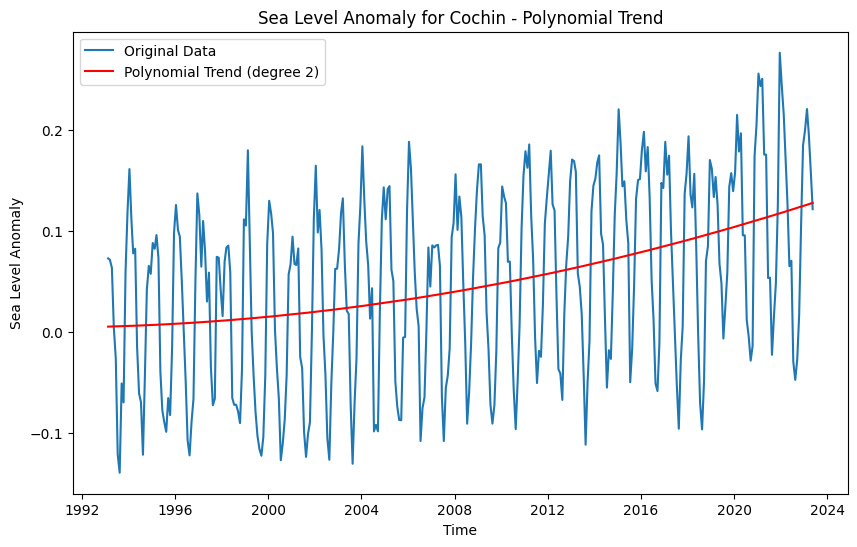

In [ ]:
for port in ['Vishakhapatnam', 'Kandla', 'Mumbai', 'Paradip', 'Cochin']:
      # Calculate and plot trend line
    trend_poly = model.predict(X_poly)
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, y, label='Original Data')
    plt.plot(data.index, trend_poly, color='red', label='Polynomial Trend (degree 2)')
    plt.title(f'Sea Level Anomaly for {port} - Polynomial Trend')
    plt.xlabel('Time')
    plt.ylabel('Sea Level Anomaly')
    plt.legend()
    plt.show()

In [ ]:
# Convert results to DataFrame for better visualization
poly_trend_df = pd.DataFrame.from_dict(poly_trend_results, orient='index')
poly_trend_df.reset_index(inplace=True)
poly_trend_df.rename(columns={'index': 'Port'}, inplace=True)

print(poly_trend_df)

             Port                                       coefficients  \
0  Vishakhapatnam  [0.0, 0.00032196436812250865, 1.76502442087724...   
1          Kandla  [0.0, -1.7896469446507254e-05, 1.0406171436096...   
2          Mumbai  [0.0, 1.2360502696042111e-05, 1.01256583623575...   
3         Paradip  [0.0, 0.00030243686994327584, 2.00973930909341...   
4          Cochin  [0.0, 5.3957871161555835e-05, 7.8313194688458e...   

   intercept  r_squared  
0  -0.020474   0.152121  
1  -0.001877   0.316288  
2   0.010745   0.323081  
3  -0.022126   0.096385  
4   0.005092   0.148921  


**Analysis of Polynomial Regression Results**

The polynomial regression results for each port include three main metrics:

* **Coefficients:** These represent the parameters for the polynomial terms, starting from the intercept term and moving to higher degrees (e.g., t and t2 terms).
* **Intercept:** The initial sea level anomaly value when time is zero, adjusted for the polynomial trend.
* **R2 score:** This shows the fit quality of the polynomial model for each port.



**Interpretation of Results for Each Port**

1.  **Vishakhapatnam**:
* **Coefficients:** The quadratic term t2 has a positive value, suggesting a slight upward curvature, meaning sea level anomalies may be accelerating.
* **Intercept:** -0.020, which is the starting point.
* **R2:** 0.152, indicating the polynomial model only moderately captures the variation in the data.

2. **Kandla:**
* **Coefficients:** The linear term is very close to zero, and the quadratic term is small but positive, suggesting a slight upward non-linear trend.
* **Intercept:** -0.0019, close to zero.
* **R2:** 0.316, indicating that the polynomial model fits the data relatively well, better than a simple linear model.

3. **Mumbai:**
* **Coefficients:** The quadratic term is close to 1, indicating a steady but minor upward curve in sea level anomalies.
* **Intercept:** 0.0107.
* **R2:** 0.323, showing an improvement over the linear fit, capturing more of the anomaly variation.

4. **Paradip:**
* **Coefficients:** The polynomial terms show a positive trend, but R2 remains low (0.096), indicating that other factors likely influence sea level variations beyond a polynomial trend.

5. **Cochin:**
* **Coefficients:** With a small positive quadratic term, the model suggests a slight increase in sea level anomalies over time.
* **Intercept:** 0.0051.
* **R2:** 0.148, a modest fit that suggests some capturing of the data’s pattern but with limited explanatory power.

**Comparison with Linear Mode**l

* Polynomial regression provided slightly higher R2 values than linear regression for Kandla and Mumbai, where the sea level anomalies seem to follow a more non-linear trend.
* However, Paradip still has a low R2, suggesting other unexplained variations, possibly due to seasonal or irregular effects.